# NSMC를 통한 감정분석

## scikit-learn의 linear classifier를 이용한 감정분석

### 0. 설계
텍스트 분류할 때 어떤 방식을 써야 성능이 점진적으로 올라가는지를 보려고, 여러가지 방법으로 학습을 할건데, 
#### 기준1. 
    1. 명사만 추출 할 것인지
    2. 전처리 하지 않고 형태소 분석 할 것인지
    3. 전처리 하고 형태소 분석 할 것인지
#### 기준2. 
    1. linear classification을 쓸 건지
    2. support vector machine, SVM을 쓸 건지
#### 더 나아가면
    1. 어떤 embedding vector을 쓸 건지
    2. layer 몇 개 쓸건지
    3. hyperparameter tuning어떻게 쓸건지

### 1. 전에 했던 nsmc 불러와서 텍스트 정제하기

In [1]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("data/nsmc/ratings_train.txt")
test_docs = read_documents("data/nsmc/ratings_test.txt")

print(len(train_docs))
print(len(test_docs))

150000
50000


### 2. 함수 정의

In [2]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1] #형태소 분석
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]


### 3. 불러온 데이터를 품사 태그를 붙여서 토크나이징 한다.

In [3]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

okt = Okt()
mecab = Mecab()

SW = define_stopwords("data/stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:#############################여기 cleaning부분 공부 필요##########################
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(line[1])]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    ###############################################################################
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[[], '0']


In [8]:
#정제를 하고나서 사라지는 데이터의 개수를 알 수 있다. 
print(len(train_docs) - len(train_data)) 
print(len(test_docs) - len(test_data))

1949
641


### 4. NLTK를 이용한 histogram 분석

In [9]:
import nltk

In [11]:
total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1138291


In [12]:
text = nltk.Text(total_tokens, name = 'NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

48018
[('영화', 57597),
 ('는데', 11464),
 ('너무', 11013),
 ('정말', 9779),
 ('으로', 9314),
 ('재밌', 8988),
 ('네요', 8978),
 ('지만', 8654),
 ('진짜', 8327),
 ('에서', 8064)]


### 5. Histogram 그리기

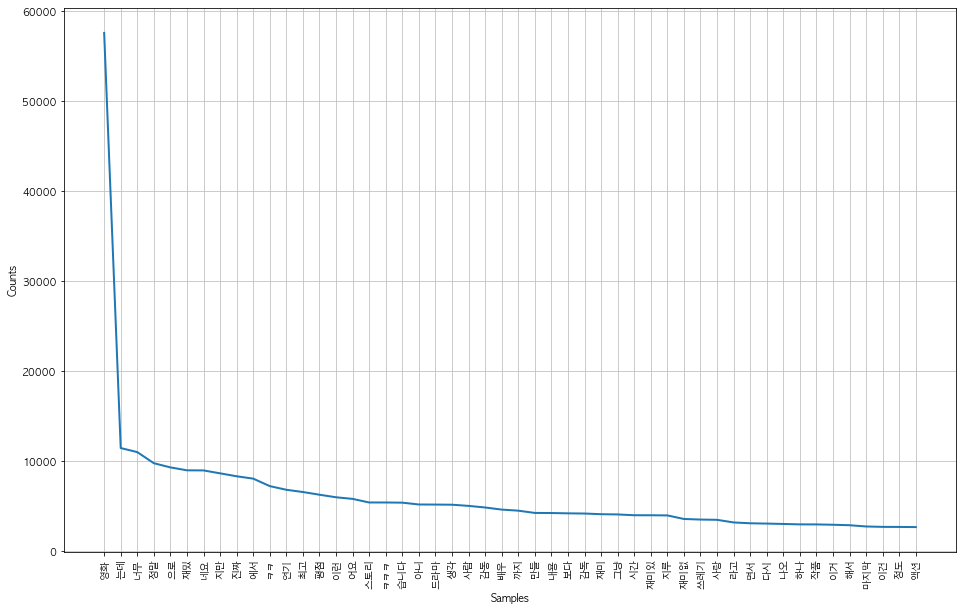

In [13]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path  =  "c:/Windows/Fonts/malgun.ttf"

if  platform.system()  ==  'Darwin':
    
    rc('font',  family='AppleGothic')

elif  platform.system()  ==  'Windows':
    
    font_name  =  font_manager.FontProperties(fname=path).get_name()
    
    rc('font',  family=font_name)

else:
    
    print('Unknown system... sorry~~~~')

    
plt.figure(figsize = (16, 10))
text.plot(50)

In [14]:
#list_to_str : 여러 리스트를 하나의 join으로 만들어주는 것
#왜 사용? 후에 사용할 counter vectorizor의 Input이 string이기 때문이다. 

def list_to_str(List) :
    return " ".join(List)

### 6. Linear Classifier와 Support Vector Machine으로 nsmc 분류하기

In [15]:
#Linear Classification에 필요한 라이브러리 불러오기
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

In [22]:
#학습을 위해 데이터 셋 모양 통일하기
#굉장히 많이 쓰는 방식 
#중요

#doc : 토크나이징된 텍스트 데이터 하나하나의 list
#list_to_str(doc) : 이걸 string으로 바꾼 걸 원소로 하는 
#doc, _ : 그것 중 doc, label 중 을 하나하나 가져와서 앞의 것(doc)만 넣어준다. 
train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
#_, label : 그것 중 doc, label 중 을 하나하나 가져와서 뒤의 것(label)만 넣어준다. 
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

In [26]:
#학습 모델 파이프라인 만들기
#linear classifier 을 사용

#1. Perceptron linear classifier
learner = Pipeline([
    ('vect', CountVectorizer(min_df= 5)),#전체 문서에서 5번 이하로 등장하는 단어는 빼버리면 하위단어가 제거되니까 약간 성능 향상을 기대해 볼 수있다. 
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100))
])

#2. SVM

In [27]:
#학습기 정하기
classifier = learner

#학습
classifier.fit(train_x, train_y)
train_predict = classifier.predict(train_x)
train_accuracy = np.mean(train_predict == train_y)

test_predict  = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)


In [28]:
#테스트 및 성능 측정
print("For %d test data : " % len(test_x))
print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : .%2f" % test_accuracy)

For 49359 test data : 
Training Accuracy : 0.80
Test Accuracy : .0.761786
